In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from itertools import combinations
from os.path import join

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

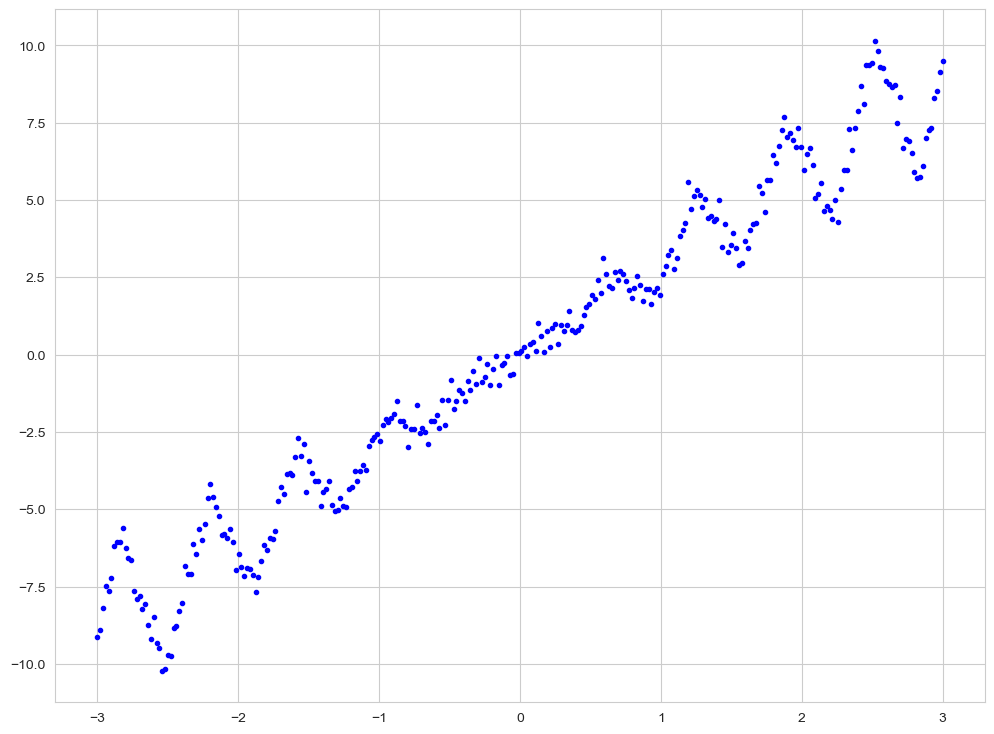

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, ax, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)

    ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

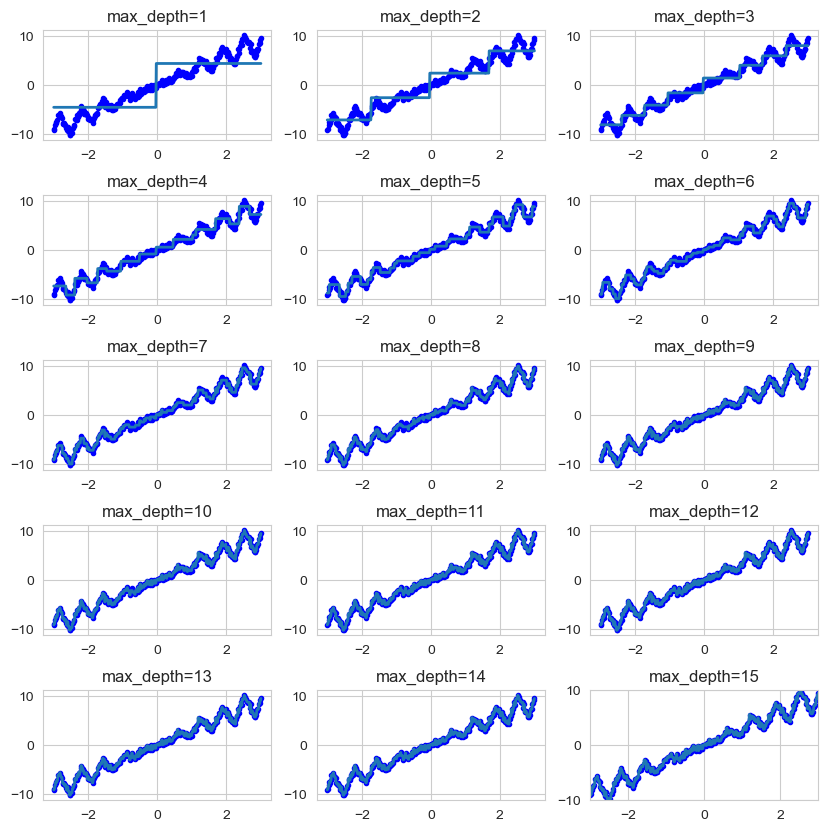

In [5]:
fig, axs = plt.subplots(5, 3, figsize = (10, 10))
plt.subplots_adjust(hspace=0.5)

for i in range(0, 15):
    test_tree = DecisionTreeRegressor(max_depth = i + 1)
    test_tree.fit(X, y)
    ax = axs[i // 3, i % 3]
    ax.plot(X.reshape(-1), y.reshape(-1), "b.")
    plot_regression_predictions(test_tree, X, y, axes =[-3, 3, -10, 10], ylabel="$y$", ax=ax)
    ax.set_title(f'max_depth={i + 1}')

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [6]:
def majority_vote(n, p):
    return sum(math.comb(n, i) * p ** i * (1 - p) ** (n - i) for i in range(round(n / 2), n + 1))

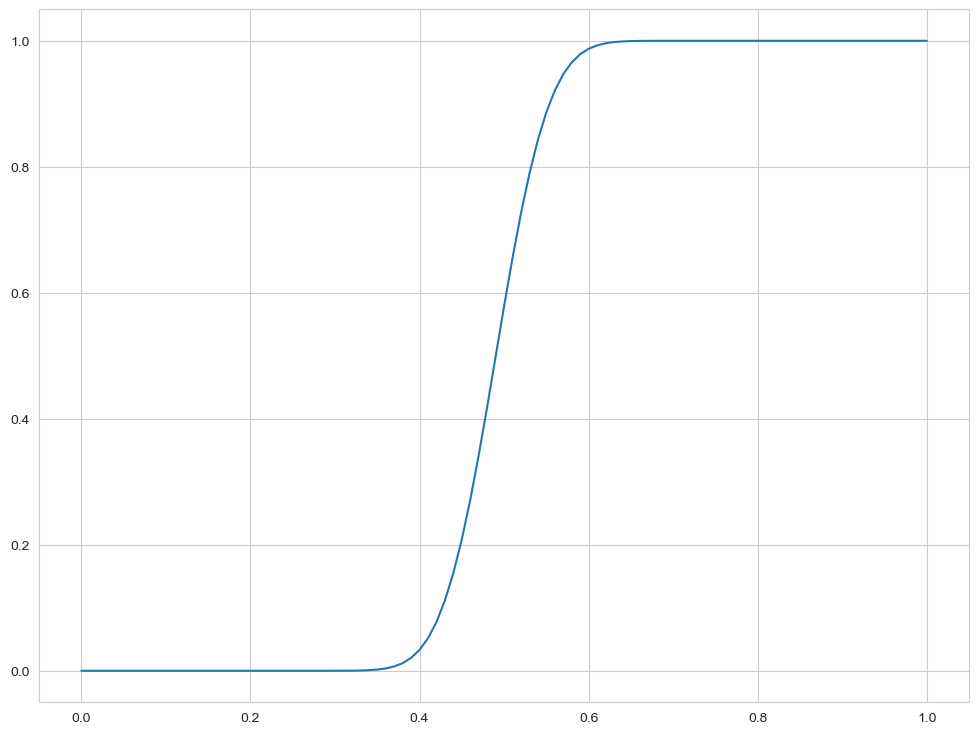

In [7]:
p_values = np.arange(0, 1.01, 0.01, dtype = np.float64)
plt.plot(p_values, [majority_vote(101, p) for p in p_values])

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

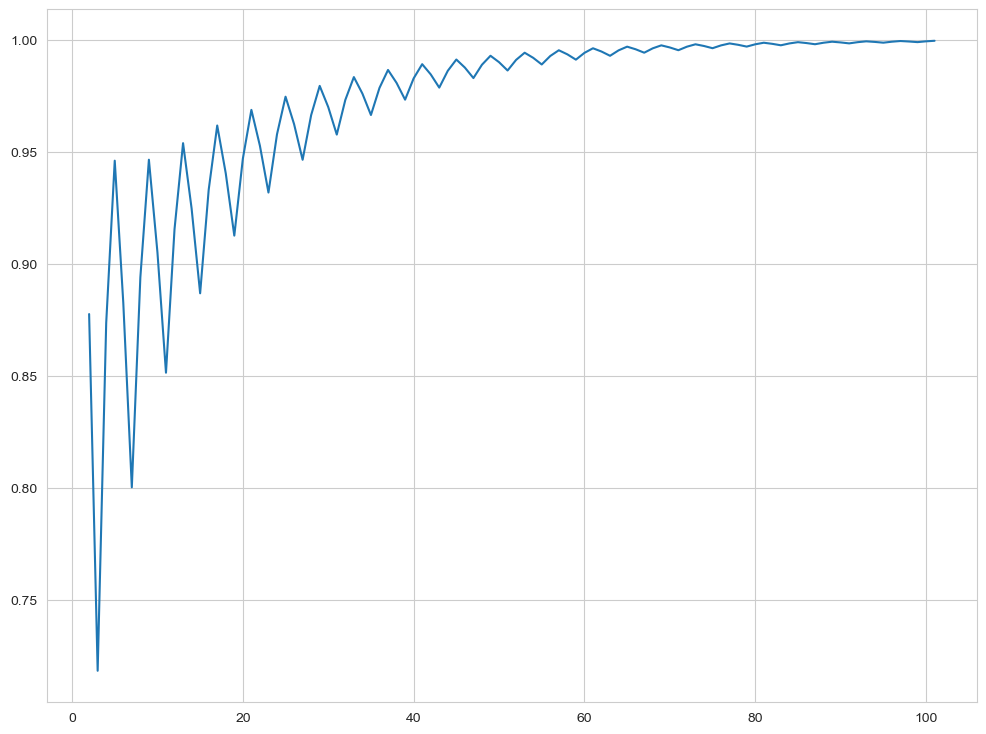

In [8]:
number_of_models = np.arange(2, 102, 1)
plt.plot(number_of_models, [majority_vote(n, 0.65) for n in number_of_models])

Опишите ваши наблюдения:

* Из первого графика видно, что чем выше вероятность правильного предсказания у моделей, тем выше общая вероятность правильного предсказания. Однако при высоких значениях вероятности правильного предсказания у моделей общая вероятность выходит на плато (стремится к 1), и дальнейшее повышение не имеет ощутимого эффекта по понятным причинам. Это значит, что может быть не обязательно подбирать модели с очень высокими значениями р, что показывает нам полезность ансамблирования.
* Вероятность правильного предсказания также в целом имеет тренд на увеличение с увеличением количества моделей. И здесь тоже можно наблюдать выход на плато.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feature_indices = np.random.choice(np.arange(X.shape[1]), size = self.max_features, replace = False)
            self.feat_ids_by_tree.append(feature_indices)
            pseudosample_indices = np.random.choice(np.arange(X.shape[0]), size = X.shape[0], replace = True)
            X_pseudosample = X[pseudosample_indices][:, feature_indices]
            y_pseudosample = y[pseudosample_indices]
            tree = DecisionTreeClassifier(max_depth = self.max_depth, max_features = self.max_features, 
                                                      random_state = self.random_state + i)
            tree.fit(X_pseudosample, y_pseudosample)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred = []
        for tree, features in zip(self.trees, self.feat_ids_by_tree):
            y_pred.append(tree.predict_proba(X[:, features]))
        return np.average(y_pred, axis = 0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

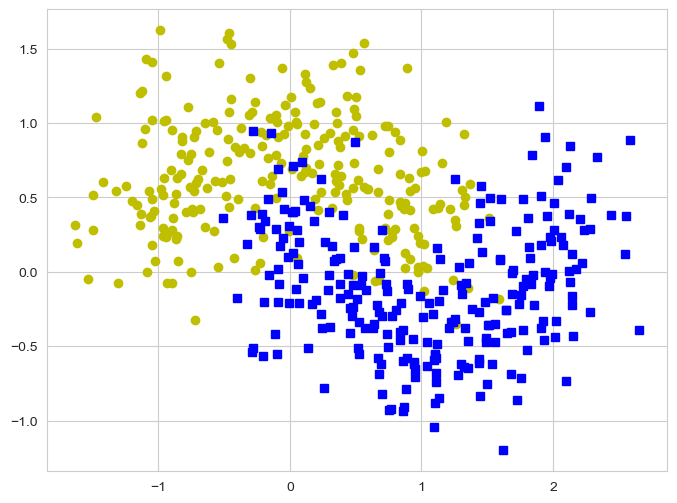

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

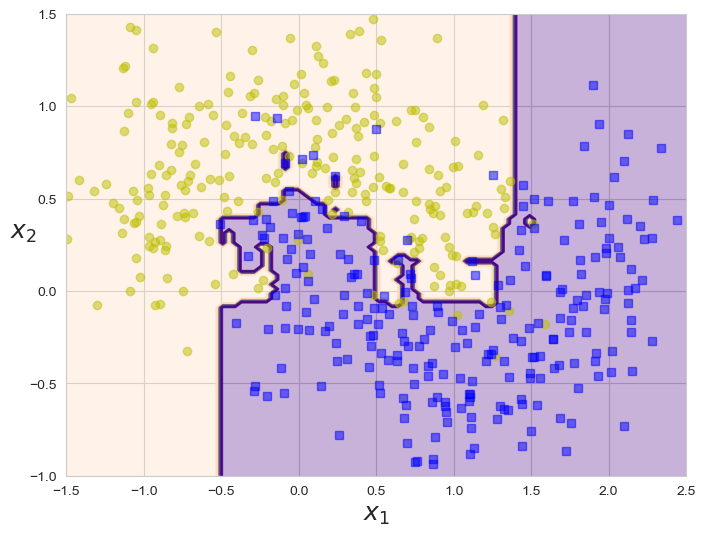

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
random_forest = RandomForestClassifierCustom(n_estimators=60, max_depth=20, max_features=2, random_state=SEED)
random_forest.fit(X_train, y_train)
plot_decision_boundary(random_forest, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [14]:
grid_params = {
    'n_estimators': list(range(50, 950, 50)),
    'max_depth': list(range(1, 10))
}

metric = 'f1'
gridsearch = GridSearchCV(random_forest, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'max_depth': 5, 'n_estimators': 300}

Best f1 score is 0.9169502753831612


In [15]:
grid_params = {
    'n_estimators': list(range(200, 400, 10)),
    'max_depth': list(range(1, 10))
}
metric = 'f1'
gridsearch = GridSearchCV(random_forest, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'max_depth': 5, 'n_estimators': 230}

Best f1 score is 0.9169502753831612


In [16]:
grid_params = {
    'n_estimators': list(range(200, 300, 1)),
    'max_depth': list(range(1, 10))
}
metric = 'f1'
gridsearch = GridSearchCV(random_forest, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'max_depth': 5, 'n_estimators': 203}

Best f1 score is 0.9169502753831612


Я также пробовал accuracy и balanced_accuracy, подобранные гиперпараметры не различались.

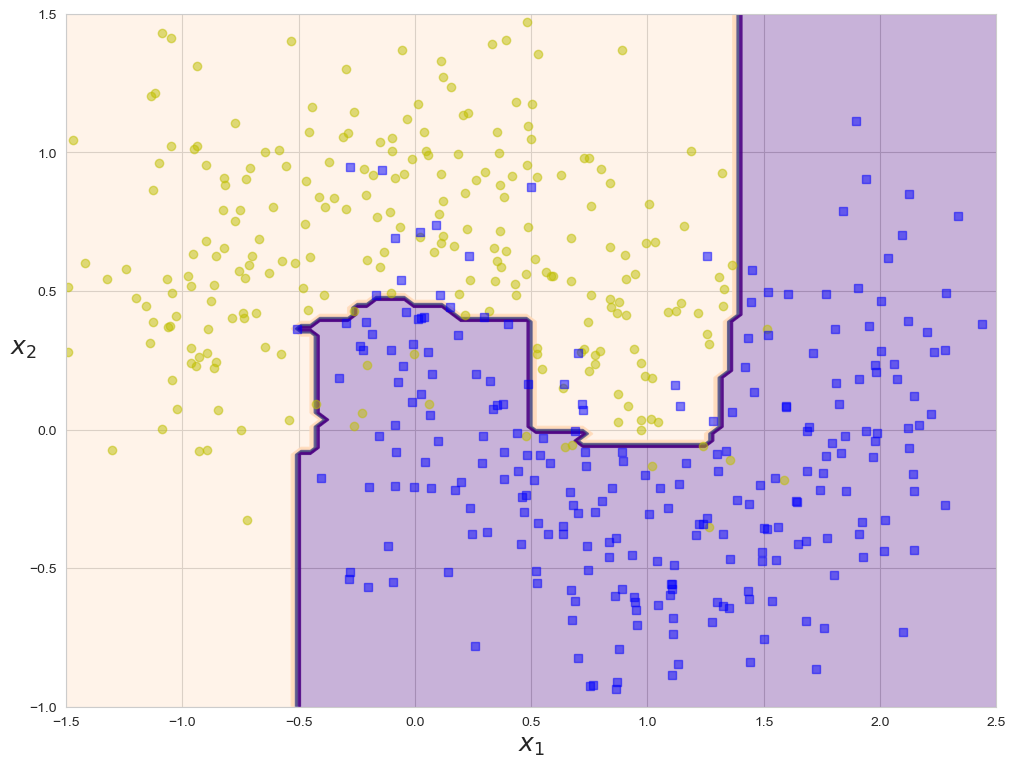

In [17]:
random_forest = RandomForestClassifierCustom(n_estimators=203, max_depth=5, max_features=2, random_state=SEED)
random_forest.fit(X_train, y_train)
plot_decision_boundary(random_forest, X, y)

Визуализация выглядит достаточно хорошо, посмотрим на значение метрики:

In [18]:
f1_score(y_test, random_forest.predict(X_test))

0.9166666666666666

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [19]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [20]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [21]:
X.shape

(569, 30)

In [22]:
def calculate_correlations(X_train, y_train, X_test, max_features = None, max_depth = None):
    random_forest = RandomForestClassifier(max_features = max_features, max_depth = max_depth, n_jobs = -1)
    random_forest.fit(X_train, y_train)
    return base_model_pair_correlation(random_forest, X_test)

In [23]:
correlations = []
for i in range(1, 31):
    correlations.append(calculate_correlations(X_train, y_train, X_test, max_features = i))

<Axes: >

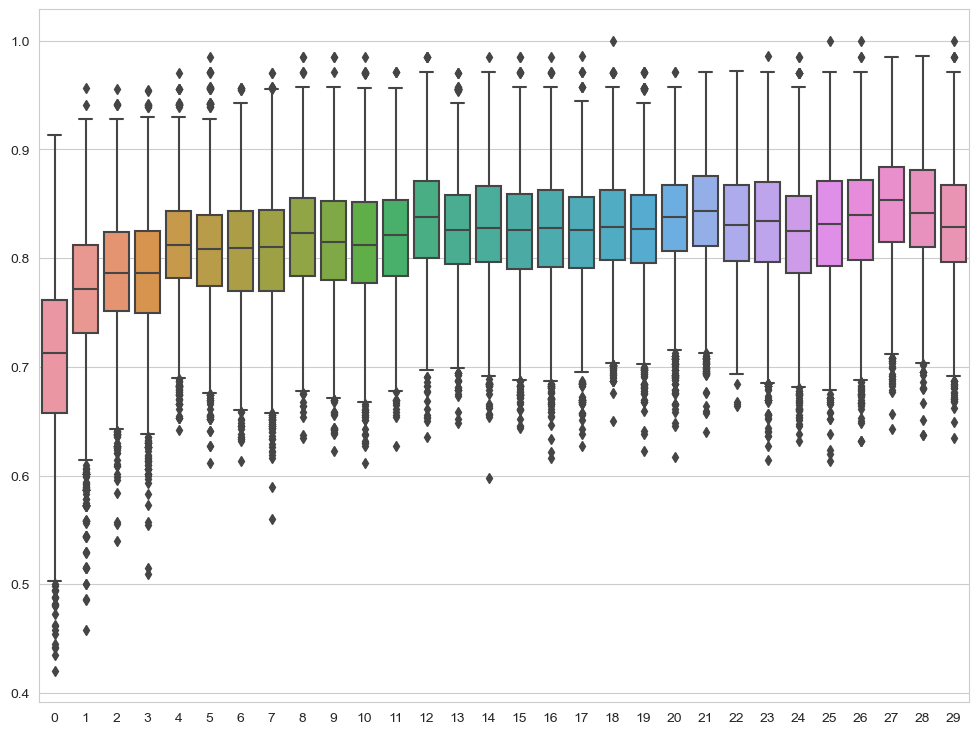

In [24]:
sns.boxplot(data=pd.DataFrame(correlations).transpose())

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [25]:
correlations_max_depth = []
for i in range(1, 31):
    correlations_max_depth.append(calculate_correlations(X_train, y_train, X_test, max_depth = i))

<Axes: >

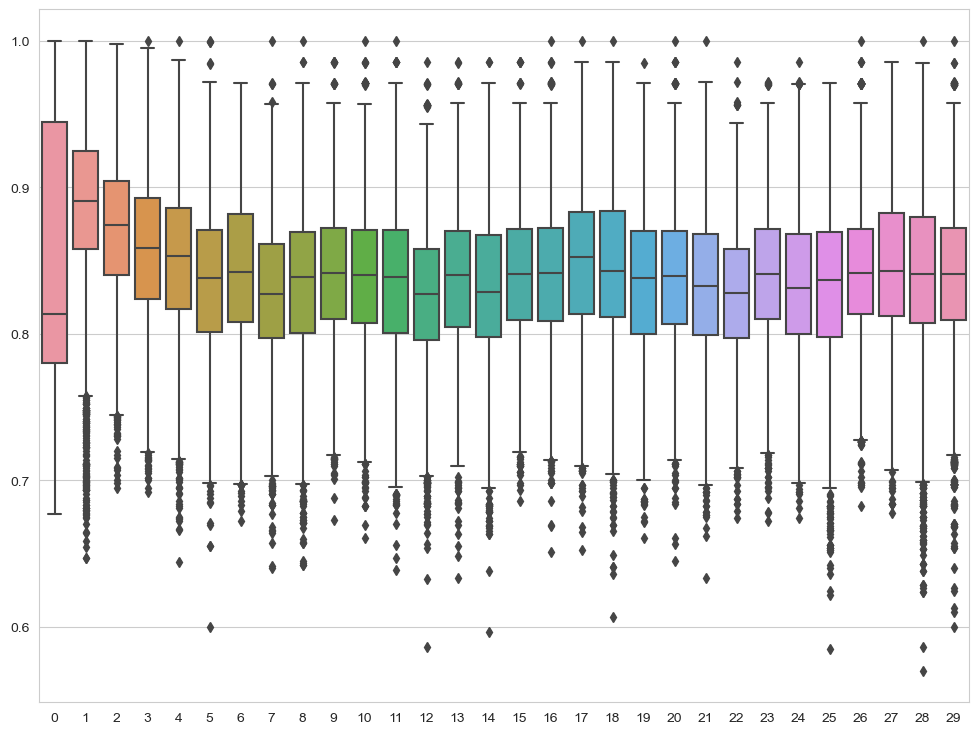

In [26]:
sns.boxplot(data=pd.DataFrame(correlations_max_depth).transpose())

Опишите ваши наблюдения:

* max_features: при значении 1 корреляция наименьшая, далее до 7 она постепенно возрастает, а затем практически не меняется. 
* max_depth: сначала постепенно снижается, после 7 остается приблизительно на одном уровне. 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [27]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv(join("..", "data", "heart.csv"))

In [28]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [29]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbosity = -1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, verbosity = -1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [35]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8463991769547325
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [36]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [37]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [38]:
correlations_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X) #берем, т.к. показал наилучшее значение

In [39]:
pd.DataFrame(correlations_soft, columns = ['model_1', 'model_2', 'value']).sort_values(by = 'value', ascending = False).head(15)

,model_1,model_2,value
64,"LGBMClassifier(random_state=111, verbosity=-1)","XGBClassifier(base_score=None, booster=None, c...",0.990632
57,<catboost.core.CatBoostClassifier object at 0x...,"LGBMClassifier(random_state=111, verbosity=-1)",0.987400
16,"(DecisionTreeClassifier(max_features='sqrt', r...",<catboost.core.CatBoostClassifier object at 0x...,0.983311
59,<catboost.core.CatBoostClassifier object at 0x...,"XGBClassifier(base_score=None, booster=None, c...",0.978323
17,"(DecisionTreeClassifier(max_features='sqrt', r...","LGBMClassifier(random_state=111, verbosity=-1)",0.974589
29,"(ExtraTreeClassifier(random_state=481767252), ...","XGBClassifier(base_score=None, booster=None, c...",0.970791
12,"(DecisionTreeClassifier(max_features='sqrt', r...","(ExtraTreeClassifier(random_state=481767252), ...",0.968670
26,"(ExtraTreeClassifier(random_state=481767252), ...",<catboost.core.CatBoostClassifier object at 0x...,0.968586
19,"(DecisionTreeClassifier(max_features='sqrt', r...","XGBClassifier(base_score=None, booster=None, c...",0.968047
27,"(ExtraTreeClassifier(random_state=481767252), ...","LGBMClassifier(random_state=111, verbosity=-1)",0.963169


Мы, конечно, можем начать убирать модели с очень высокой корреляцией с другими, но я попробовал и понял, что найти самый лучший результат так будет непросто. Давайте попробуем найти лучший вариант перебором:

In [40]:
model_combinations = []
for i in range(1, len(base_models) + 1):
    for model_combination in combinations(base_models, i):
        model_combinations.append(list(model_combination))

In [41]:
answer = [0, 'nothing']
for combination in model_combinations:
    voting = VotingClassifier(estimators=combination, voting='soft')
    voting.fit(X_train, y_train)
    current_score = f1_score(y_test, voting.predict(X_test))
    if current_score > answer[0]:
        answer[0] = current_score
        answer[1] = combination

In [42]:
print(answer)

[0.9166666666666666, [('ETC', ExtraTreesClassifier(random_state=111)), ('LR', LogisticRegression(max_iter=10000, solver='liblinear')), ('NB', GaussianNB())]]


Подсчет занял около трех часов, причем лучший результат был найден в первые 6 минут работы кода. В данном случае считаю такой способ решения оправданным. Однако нужно отметить, что если бы количество гиперпараметров было значительно больше, либо время подсчета было более длинным, и мы не ставили бы себе целью найти *самое* лучшее решение, то было бы рациональнее вручную убирать коррелирующие модели или использовать RandomizedSearchCV.

На всякий случай проверим:

In [30]:
base_models_chosen = [("ETC", etc), ("LR", lr), ("NB", nb)]

In [31]:
voting = VotingClassifier(estimators=base_models_chosen, voting='soft')
voting.fit(X_train, y_train)
f1_score(y_test, voting.predict(X_test))

0.9166666666666666

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [3]:
data = pd.read_csv(join("..", "data", "churn.csv"))
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

'Phone' можно удалить, а некоторые переменные - перекодировать:

In [6]:
data = data.drop('Phone', axis = 1)
data.replace({"Int'l Plan": {'no': 0, 'yes': 1}}, inplace = True)
data.replace({"VMail Plan": {'yes': 1, 'no': 0}}, inplace = True)
data.replace({"Churn?": {'True.': 1, 'False.': 0}}, inplace = True)
data.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [7]:
data['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [8]:
data['State'].value_counts()

State
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: count, dtype: int64

Очень много категорий - считаю неразумным перекодировать, и нет такого, чтобы один или несколько штатов доминировали, чтобы перекодировать данные так. Удаляю.

In [9]:
data = data.drop('State', axis = 1)

array([[<Axes: title={'center': 'Churn?'}>]], dtype=object)

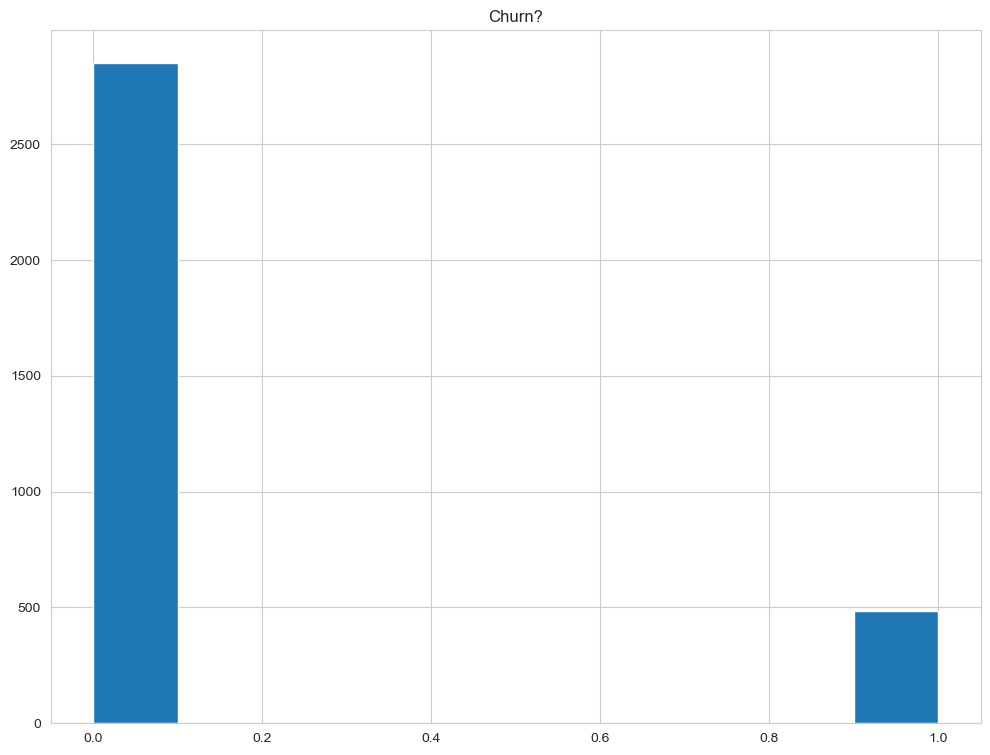

In [10]:
data[['Churn?']].hist()

Видим дисбаланс - надо будет учесть:

In [11]:
X = data.drop(["Churn?"], axis=1)
y = data["Churn?"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=SEED)

In [14]:
xg_boost = xgboost.XGBRFClassifier(random_state = SEED)

Из метрик я выбрал f1, потому что мои данные достаточно несбалансированные. Я еще пробовал accuracy, и там получались параметры 'learning_rate': 0.95, 'max_depth': 5, 'max_leaves': 18, 'n_estimators': 54, и значение метрики в 0.94, но по описанной выше причине я не очень доверяю ему.

После ознакомления с разнообразной информацией о гиперпараметрах XGBoost в сети Интернет, я выбрал следующие: **n_estimators**, **max_depth**, **learning_rate**. **gamma** я исключил, т.к. здесь у меня не очень сложная структура данных и, соответственно, нет нужды в очень глубоких деревьях, с overfitting-ом которых мог бы помочь подбор этого параметра. По похожей причине я не трогал **subsample**. **min_child_weight** и некоторые другие параметры я, немного попробовав, по итогу тоже здесь не проверяю. Я принял такое решение потому что, как будет видно ниже, уже с имеющимися 3 параметрами я подобрал как будто достаточно хорошие значения метрики. Безусловно, можно пытаться увеличить их еще, но трата, возможно, часов на то, чтобы поднять значение метрики на пару процентов видится мне нерациональной. Ведь в конкретно этом случае речь не идет, например, о разработке лекарства, где каждый процент на счету, потому что цена ошибки огромна.

In [43]:
grid_params = {
    'n_estimators': list(range(50, 950, 100)),
    'max_depth': list(range(1, 10)),
    'learning_rate': list(np.arange(0, 1, 0.1))
}

metric = 'f1'
gridsearch = GridSearchCV(xg_boost, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'learning_rate': 0.8, 'max_depth': 9, 'n_estimators': 350}

Best f1 score is 0.7840052865675434


In [45]:
grid_params = {
    'n_estimators': list(range(200, 500, 10)),
    'max_depth': list(range(1, 15)),
    'learning_rate': list(np.arange(0.5, 1.05, 0.05))
}

metric = 'f1'
gridsearch = GridSearchCV(xg_boost, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'learning_rate': 1.0000000000000004, 'max_depth': 10, 'n_estimators': 460}

Best f1 score is 0.7858278873970491


In [46]:
grid_params = {
    'n_estimators': [300, 600, 1],
    'max_depth': [10],
    'learning_rate': [1]
}

metric = 'f1'
gridsearch = GridSearchCV(xg_boost, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 600}

Best f1 score is 0.7858278873970491


Значение принципиально не улучшается, поэтому оставим так:

In [19]:
xg_boost = xgboost.XGBRFClassifier(learning_rate = 1, max_depth = 10, n_estimators = 600, random_state = SEED)
xg_boost.fit(X_train, y_train)
f1_score(y_test, xg_boost.predict(X_test))

0.7941176470588237

Нам даже удалось немного улучшить значения по сравнению с автоматическими:

In [23]:
xg_boost_not_specified = xgboost.XGBRFClassifier(random_state = SEED)
xg_boost_not_specified.fit(X_train, y_train)
f1_score(y_test, xg_boost_not_specified.predict(X_test))

0.7806691449814126

In [13]:
cat = catboost.CatBoostClassifier(random_state = SEED, verbose = 0)

Логика выбора или не выбора основных параметров была следующей:
**learning_rate** - не брал; автоматически подбираемое на основе свойств данных значение "должно быть достаточно близко к оптимальному", и попытка подобрать лучшее значение самостоятельно выглядит сомнительно.
**max_depth** - необходимо проверить, т.к. зависит от конкретно моих данных, разброс значений соответствует рекомендуемым.
**iterations** - обязательно надо проверить, причины сходные.
Другие гиперпараметры, немного попробовав, по итогу не брал - текущие 2 опять показывают достаточно хорошие значения accuracy, так что не считаю оправданным.

In [21]:
grid_params = {
    'max_depth': list(range(1, 10)),
    'iterations': list(range(100, 1000, 100))
}

metric = 'f1'
gridsearch = GridSearchCV(cat, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Learning rate set to 0.018151
0:	learn: 0.6767764	total: 162ms	remaining: 2m 9s
1:	learn: 0.6575866	total: 164ms	remaining: 1m 5s
2:	learn: 0.6408073	total: 167ms	remaining: 44.4s
3:	learn: 0.6260524	total: 170ms	remaining: 33.9s
4:	learn: 0.6149725	total: 173ms	remaining: 27.5s
5:	learn: 0.6002144	total: 176ms	remaining: 23.3s
6:	learn: 0.5836775	total: 179ms	remaining: 20.2s
7:	learn: 0.5721356	total: 181ms	remaining: 17.9s
8:	learn: 0.5620108	total: 185ms	remaining: 16.2s
9:	learn: 0.5529086	total: 188ms	remaining: 14.9s
10:	learn: 0.5420684	total: 191ms	remaining: 13.7s
11:	learn: 0.5338418	total: 194ms	remaining: 12.8s
12:	learn: 0.5208397	total: 197ms	remaining: 11.9s
13:	learn: 0.5113276	total: 201ms	remaining: 11.3s
14:	learn: 0.5012468	total: 204ms	remaining: 10.7s
15:	learn: 0.4912816	total: 207ms	remaining: 10.2s
16:	learn: 0.4800596	total: 211ms	remaining: 9.71s
17:	learn: 0.4709850	total: 214ms	remaining: 9.3s
18:	learn: 0.4608593	total: 218ms	remaining: 8.94s
19:	learn: 0

218:	learn: 0.1583962	total: 784ms	remaining: 2.08s
219:	learn: 0.1580395	total: 787ms	remaining: 2.08s
220:	learn: 0.1578006	total: 790ms	remaining: 2.07s
221:	learn: 0.1574157	total: 794ms	remaining: 2.07s
222:	learn: 0.1571148	total: 796ms	remaining: 2.06s
223:	learn: 0.1569354	total: 799ms	remaining: 2.06s
224:	learn: 0.1568033	total: 802ms	remaining: 2.05s
225:	learn: 0.1566626	total: 805ms	remaining: 2.04s
226:	learn: 0.1562989	total: 808ms	remaining: 2.04s
227:	learn: 0.1560279	total: 812ms	remaining: 2.04s
228:	learn: 0.1558665	total: 815ms	remaining: 2.03s
229:	learn: 0.1556251	total: 818ms	remaining: 2.03s
230:	learn: 0.1554969	total: 821ms	remaining: 2.02s
231:	learn: 0.1552610	total: 824ms	remaining: 2.02s
232:	learn: 0.1551433	total: 828ms	remaining: 2.01s
233:	learn: 0.1548910	total: 831ms	remaining: 2.01s
234:	learn: 0.1547101	total: 833ms	remaining: 2s
235:	learn: 0.1544872	total: 836ms	remaining: 2s
236:	learn: 0.1542511	total: 839ms	remaining: 1.99s
237:	learn: 0.1540

440:	learn: 0.1242241	total: 1.39s	remaining: 1.13s
441:	learn: 0.1241572	total: 1.39s	remaining: 1.13s
442:	learn: 0.1241178	total: 1.4s	remaining: 1.13s
443:	learn: 0.1241057	total: 1.4s	remaining: 1.12s
444:	learn: 0.1240562	total: 1.4s	remaining: 1.12s
445:	learn: 0.1239876	total: 1.41s	remaining: 1.11s
446:	learn: 0.1239144	total: 1.41s	remaining: 1.11s
447:	learn: 0.1238352	total: 1.41s	remaining: 1.11s
448:	learn: 0.1237598	total: 1.41s	remaining: 1.1s
449:	learn: 0.1237373	total: 1.42s	remaining: 1.1s
450:	learn: 0.1237100	total: 1.42s	remaining: 1.1s
451:	learn: 0.1235966	total: 1.42s	remaining: 1.09s
452:	learn: 0.1235098	total: 1.43s	remaining: 1.09s
453:	learn: 0.1233600	total: 1.43s	remaining: 1.09s
454:	learn: 0.1232396	total: 1.43s	remaining: 1.08s
455:	learn: 0.1231991	total: 1.43s	remaining: 1.08s
456:	learn: 0.1229978	total: 1.44s	remaining: 1.08s
457:	learn: 0.1229215	total: 1.44s	remaining: 1.07s
458:	learn: 0.1228828	total: 1.44s	remaining: 1.07s
459:	learn: 0.1228

659:	learn: 0.1048999	total: 1.98s	remaining: 421ms
660:	learn: 0.1047488	total: 1.99s	remaining: 418ms
661:	learn: 0.1047112	total: 1.99s	remaining: 415ms
662:	learn: 0.1046128	total: 1.99s	remaining: 412ms
663:	learn: 0.1045192	total: 2s	remaining: 409ms
664:	learn: 0.1044164	total: 2s	remaining: 406ms
665:	learn: 0.1043221	total: 2s	remaining: 403ms
666:	learn: 0.1042036	total: 2s	remaining: 399ms
667:	learn: 0.1041664	total: 2.01s	remaining: 396ms
668:	learn: 0.1040789	total: 2.01s	remaining: 394ms
669:	learn: 0.1040647	total: 2.01s	remaining: 390ms
670:	learn: 0.1040019	total: 2.02s	remaining: 387ms
671:	learn: 0.1039275	total: 2.02s	remaining: 384ms
672:	learn: 0.1038132	total: 2.02s	remaining: 381ms
673:	learn: 0.1037911	total: 2.02s	remaining: 378ms
674:	learn: 0.1037225	total: 2.03s	remaining: 375ms
675:	learn: 0.1035511	total: 2.03s	remaining: 372ms
676:	learn: 0.1035059	total: 2.03s	remaining: 369ms
677:	learn: 0.1034001	total: 2.03s	remaining: 366ms
678:	learn: 0.1032322	to

In [16]:
grid_params = {
    'max_depth': list(range(1, 10, 1)),
    'iterations': list(range(600, 1000, 100))
}

metric = 'f1'
gridsearch = GridSearchCV(cat, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'iterations': 800, 'max_depth': 5}

Best f1 score is 0.8217253881747999


In [17]:
grid_params = {
    'max_depth': list(range(1, 10, 1)),
    'iterations': list(range(700, 900, 10))
}

metric = 'f1'
gridsearch = GridSearchCV(cat, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'iterations': 750, 'max_depth': 5}

Best f1 score is 0.8269251892089967


In [18]:
grid_params = {
    'max_depth': [5],
    'iterations': list(range(700, 800, 1))
}

metric = 'f1'
gridsearch = GridSearchCV(cat, param_grid = grid_params, scoring = metric, n_jobs = -1)
gridsearch.fit(X_train, y_train)
print(f'Best hyperparameters are: {gridsearch.best_params_}\n\nBest {metric} score is {gridsearch.best_score_}')

Best hyperparameters are: {'iterations': 701, 'max_depth': 5}

Best f1 score is 0.8297314146319998


Результат улучшается не очень существенно, поэтому оставим гиперпараметры такими:

In [22]:
cat = catboost.CatBoostClassifier(random_state = SEED, verbose = 0, iterations = 700, max_depth = 5)
cat.fit(X_train, y_train)
f1_score(y_test, cat.predict(X_test))

0.842911877394636

Опять, немного улучшили:

In [24]:
autocat = catboost.CatBoostClassifier(random_state = SEED, verbose = 0)
autocat.fit(X_train, y_train)
f1_score(y_test, autocat.predict(X_test))

0.8396946564885496

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [63]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

Миниатюра - я и домашка по ML (гипертрофировано для драматического эффекта):


![domashka ml and me](../data/me_and_ml_domashka.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

В этот раз было не очень просто, не очень сложно. Были некоторые трудности вначале, где надо код писать, но вроде бы преодолелись... Печалит что приходится часами сидеть-ждать, пока подбираются параметры, невозможно что-то другое в это время вяполнять на ноутбуке. Надеюсь, если потребности в вычислительных мощностях будут расти, появится возможность какого-то удаленного подсчета...